In [75]:
# @title Paso 1: Importar Dependencias {form-width: "25%"}

import cv2
from cv2 import imshow
import numpy as np
# from google.colab import files
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def plot_line_graph(data_list, labels=None, title=None, x_label="frames", figsize=(8, 6), legend_font_size=14):
    x = range(len(data_list[0]))  # Assuming all data arrays have the same length
    colors = ['b', 'g', 'r', 'p']  # You can customize the colors here

    fig, ax = plt.subplots(figsize=figsize)

    # Set white background and adjust text color
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

    for i, y in enumerate(data_list):
        if labels and len(labels) > i:
            label = labels[i]
        else:
            label = f"Line {i+1}"

        if i < 3:
            plt.plot(x, y, color=colors[i], label=label)
        else:
            plt.plot(x, y, label=label)  # Use default color for lines beyond the first three

    plt.xlabel(x_label)
    plt.title(title)
    plt.legend(loc='best', fontsize=legend_font_size)
    plt.show()

# !wget -O video.mp4 "https://drive.google.com/uc?export=download&id=1-l9vGMprjF-FuYjGpcn03_JTpx1f0Q-f"
VIDEO_PATH = "D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/video1_30s.mp4"
NFEARURES = 1000
DOWNSCALE_RATIO = 1
METHOD = "orb"

In [76]:
# @title Paso 1: Implementar Filtro de Kalman {form-width: "25%"}

def kalman_implementation(measurements, initial_mu,  tag="measurments"):
  F = np.array([[1., 1.],[0., 1.]]) # a model  describes how the state evolves from one time step to the next
  x = np.array([float(initial_mu), 1.]) # initial state (transformation and velocity)
  P = np.eye(2) * 100. # initial uncertainty 2x2 matrix (starts with high uncertainty 100)

  std_noise = np.std(measurements) # the standard deviation of the measurement noise

  kf = KalmanFilter(dim_x=2, dim_z=1)
  kf.x = np.array([x]).T # initial state (location and velocity)
  kf.F = F.copy()        # state transition matrix
  kf.P = P.copy()        # covariance matrix
  kf.R *= std_noise**2   # measurement noise variance also called uncertainty
  kf.Q = Q_discrete_white_noise(2, 1., .001) # process noise covariance matrix generated using Q_discrete_white_noise
  kf.H = np.array([[1., 0.]]) # is set to the measurement matrix, which maps the state to the measurement space.

  ps = []
  kf_results = []

  for measurement in measurements:
    kf.predict()
    kf.update(measurement)
    kf_results.append(kf.x[0,0])
    ps.append(kf.P[0,0]**.5)

  kf_results = np.asarray(kf_results)
  ps = np.asarray(ps)

  # Plot the results
  plt.subplots(figsize=(10, 6))
  plt.plot(kf_results, label='KF', c='b', lw=2)
  plt.plot(measurements, label=tag, c='r', lw=2, linestyle=':')
  # plt.plot (kf_results - ps, c='k',linestyle=':', lw=1, label='1$\sigma$')
  # plt.plot(kf_results + ps, c='k', linestyle=':', lw=1)
  # plt.fill_between(range(len(measurements)), kf_results - ps, kf_results + ps, facecolor='y', alpha=.3)
  plt.legend(loc='best', fontsize=14)
  plt.show()
  
  return kf_results

In [77]:
# @title Paso 2: Obtener matriz Afín {form-width: "25%"}

def downscale_frame(frame, n):
  height, width, _ = frame.shape
  new_height = int(height * n)
  new_width = int(width * n)

  downscaled_frame = cv2.resize(frame, (new_width, new_height))
  return downscaled_frame

def get_orb_affine_transformations(image1, image2):
  # Detectar Keypoints y descriptores para cada frame
  orb = cv2.ORB_create(nfeatures=NFEARURES)
  keypoints1, descriptors1 = orb.detectAndCompute(image1, mask=None)
  keypoints2, descriptors2 = orb.detectAndCompute(image2, mask=None)

  # Emparejar Caracteristicas
  matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
  matches = matcher.match(descriptors1, descriptors2)

  feature_rate = 1
  total_matches = len(matches)
  work_matches = int(total_matches * feature_rate)  # la cantidad de caracteristicas con las que vamos a trabajar
  matches = sorted(matches, key=lambda x: x.distance)[:work_matches]

  # Obtener Keypoints de las caracteristcias
  src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

  if len(src_pts) != len(dst_pts) or (len(src_pts), len(dst_pts)) == (0, 0):
    return np.matrix([[1, 0, 0], [0, 1, 0]])
  
  # Estimar una matriz de transformación Afín
  affine_matrix, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts, confidence= 0.8, method=cv2.RANSAC)

  if affine_matrix is None:
    return np.matrix([[1, 0, 0], [0, 1, 0]])
  
  return affine_matrix

def get_sift_affine_transformations(image1, image2):
  # Detectar Keypoints y descriptores para cada frame
  gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
  gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
  
  sift = cv2.SIFT_create(nfeatures=NFEARURES)
  keypoints1, descriptors1 = sift.detectAndCompute(gray_image1, mask=None)
  keypoints2, descriptors2 = sift.detectAndCompute(gray_image2, mask=None)

  # Convert descriptors to the appropriate data type
  descriptors1 = descriptors1.astype(np.float32)
  descriptors2 = descriptors2.astype(np.float32)

  # Emparejar Caracteristicas
  matcher = cv2.BFMatcher(cv2.NORM_L2)
  matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

  good_matches = []
  for m, n in matches:
      if m.distance < 0.5 * n.distance:
          good_matches.append(m)
  good_matches = np.asarray(good_matches)

  # Obtener Keypoints de las caracteristcias
  src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

  if len(src_pts) != len(dst_pts) or (len(src_pts), len(dst_pts)) == (0, 0):
    return np.matrix([[1, 0, 0], [0, 1, 0]])
  
  affine_matrix, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts, confidence=0.8, method=cv2.RANSAC)
  
  return affine_matrix



def extract_transformation_matrix(image1, image2, method="orb"):
  if method == "orb":
    transformation_matrix = get_orb_affine_transformations(image1, image2)
  elif method == "sift":
    transformation_matrix = get_sift_affine_transformations(image1, image2)

  return transformation_matrix


def get_video_affine_transformations(input_path, fixed_reference_frame=True, method="orb"):
  # Open the video file for reading
  video_capture = cv2.VideoCapture(input_path)
  total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
  fps = video_capture.get(cv2.CAP_PROP_FPS)

  _, reference_frame = video_capture.read()
  reference_frame = downscale_frame(reference_frame, DOWNSCALE_RATIO) # Modificamos la resolución del frame

  video_affine_transformations = [[[1, 0, 0], [0, 1, 0]]]
  frame_count = 0
  while True:
    
    ret, frame = video_capture.read()
    if not ret:
      break
    
    frame = downscale_frame(frame, DOWNSCALE_RATIO)
    # Extraer matriz afín
    affine_matrix = extract_transformation_matrix(frame, reference_frame, method=method)
    video_affine_transformations.append(affine_matrix)
    
    if not fixed_reference_frame and frame_count % fps == 0:
      reference_frame = frame
    
    frame_count += 1
    if (frame_count % 100 == 0):
      print(f"Matrices listas {frame_count}/{total_frames}")

  # Release the video capture and writer objects
  video_capture.release()

  return  np.array(video_affine_transformations)

def extract_affine_parameters(matrix_array):
  transformed_array = []
  
  for matrix in matrix_array:
    s = np.sqrt(matrix[0, 0] ** 2 + matrix[1, 0] ** 2)
    theta = np.arctan2(matrix[1, 0], matrix[0, 0])
    tx = matrix[0, 2]
    ty = matrix[1, 2]
    
    transformed_array.append(np.array([theta, s, tx, ty]))
  
  return transformed_array

def reformat_affine_parameters(parameters_array):
  inverse_transformed_array = []
  
  for params in parameters_array:
    theta = params[0]
    s = params[1]
    tx = params[2]
    ty = params[3]
    
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    matrix = np.matrix([
      [cos_theta * s, -sin_theta * s, tx],
      [sin_theta * s, cos_theta * s, ty]
    ])
    
    inverse_transformed_array.append(matrix)
  
  return inverse_transformed_array


def moving_average_filter(array, window_size):
  filtered_array = []
  window = []

  for value in array:
    window.append(value)
    if len(window) > window_size:
      window.pop(0)
    filtered_value = np.mean(window)
    filtered_array.append(filtered_value)

  return filtered_array

def downsample_and_interpolate(arr, factor):
  # Interpolate the removed values
  interpolated = []
  for i in range(len(arr) - 1):
    if i % factor == 0:
      interpolated.append(arr[i])
    else:
      # Calculate the indices of the surrounding downsampled values
      prev_index = i - (i % factor)
      next_index = prev_index + factor
      
      # If the next index is out of bounds, use the last value as the next value
      if next_index >= len(arr):
        next_value = arr[-1]
      else:
        next_value = arr[next_index]
      
      # Linearly interpolate between the surrounding values
      alpha = (i - prev_index) / float(factor)
      interpolated_value = (1 - alpha) * arr[prev_index] + alpha * next_value
      interpolated.append(interpolated_value)
  
  # Add the last value
  interpolated.append(arr[-1])
  
  return interpolated


def filter_affine_transformations(affine_transformations, with_kalman=False, with_interpolation=False):
  affine_parameters = np.array(extract_affine_parameters(affine_transformations))
  rotations = affine_parameters[:, 0]
  scaling = affine_parameters[:, 1]
  # scaling = [1 for _ in affine_parameters[:, 1]]
  x_shiftings = affine_parameters[:, 2]
  y_shiftings = affine_parameters[:, 3]
  
  if with_interpolation:
    rotations = downsample_and_interpolate(rotations, 20)
    scaling = downsample_and_interpolate(scaling, 5)
    x_shiftings = downsample_and_interpolate(x_shiftings, 20)
    y_shiftings = downsample_and_interpolate(y_shiftings, 20)

  filter_window_size = 3
  maf_rotations = moving_average_filter(rotations, filter_window_size) # maf = moving_average_filter
  maf_scaling = moving_average_filter(scaling, filter_window_size)
  maf_x_shiftings = moving_average_filter(x_shiftings, filter_window_size)
  maf_y_shiftings = moving_average_filter(y_shiftings, filter_window_size)

  kalman_rotations = kalman_implementation(maf_rotations, maf_rotations[0], tag="rotations") # maf = moving_average_filter
  kalman_scaling = kalman_implementation(maf_scaling, maf_scaling[0], tag="scaling")
  kalman_x_shiftings = kalman_implementation(maf_x_shiftings, maf_x_shiftings[0], tag="x_shiftings")
  kalman_y_shiftings = kalman_implementation(maf_y_shiftings, maf_y_shiftings[0], tag="y_shiftings")

  if with_kalman:
    affine_parameters = [np.array([kalman_rotations[i], kalman_scaling[i], kalman_x_shiftings[i], kalman_y_shiftings[i]]) for i in range(len(rotations))]
  else:
    affine_parameters = [np.array([maf_rotations[i], maf_scaling[i], maf_x_shiftings[i], maf_y_shiftings[i]]) for i in range(len(rotations))]

  reformatted_parameters = reformat_affine_parameters(affine_parameters)

  # Combine the plots into one
  fig, axes = plt.subplots(2, 2, figsize=(12, 8))

  # Plot rotations
  axes[0, 0].plot(rotations, label='rotations', c='b', lw=2)
  axes[0, 0].plot(maf_rotations, label='maf filtered', c='g', lw=2)
  axes[0, 0].plot(kalman_rotations, label='kalman', c='r', lw=2)
  axes[0, 0].legend(loc='best', fontsize=10)
  axes[0, 0].set_title('Rotations')

  # Plot scaling
  axes[0, 1].plot(scaling, label='scaling', c='b', lw=2)
  axes[0, 1].plot(maf_scaling, label='maf filtered', c='g', lw=2)
  axes[0, 1].plot(kalman_scaling, label='kalman', c='r', lw=2)
  axes[0, 1].legend(loc='best', fontsize=10)
  axes[0, 1].set_title('Scaling')

  # Plot x_shiftings
  axes[1, 0].plot(x_shiftings, label='x_shiftings', c='b', lw=2)
  axes[1, 0].plot(maf_x_shiftings, label='maf filtered', c='g', lw=2)
  axes[1, 0].plot(kalman_x_shiftings, label='kalman', c='r', lw=2)
  axes[1, 0].legend(loc='best', fontsize=10)
  axes[1, 0].set_title('X shiftings')

  # Plot y_shiftings
  axes[1, 1].plot(y_shiftings, label='y_shiftings', c='b', lw=2)
  axes[1, 1].plot(maf_y_shiftings, label='maf filtered', c='g', lw=2)
  axes[1, 1].plot(kalman_y_shiftings, label='kalman', c='r', lw=2)
  axes[1, 1].legend(loc='best', fontsize=10)
  axes[1, 1].set_title('Y shiftings')
  plt.xlabel("frames")
  plt.tight_layout()
  plt.show()

  if with_kalman:
    affine_parameters = [np.array([kalman_rotations[i], kalman_scaling[i], kalman_x_shiftings[i], kalman_y_shiftings[i]]) for i in range(len(rotations))]
  else:
    affine_parameters = [np.array([maf_rotations[i], maf_scaling[i], maf_x_shiftings[i], maf_y_shiftings[i]]) for i in range(len(rotations))]

  return reformat_affine_parameters(affine_parameters)


In [78]:
video_affine_transformations = get_video_affine_transformations(VIDEO_PATH, method=METHOD)

Matrices listas 100/901
Matrices listas 200/901
Matrices listas 300/901
Matrices listas 400/901
Matrices listas 500/901
Matrices listas 600/901
Matrices listas 700/901
Matrices listas 800/901
Matrices listas 900/901


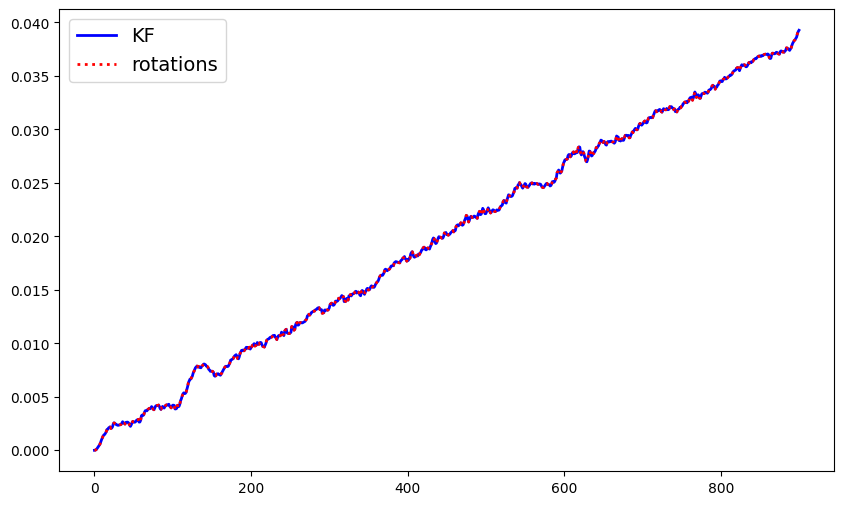

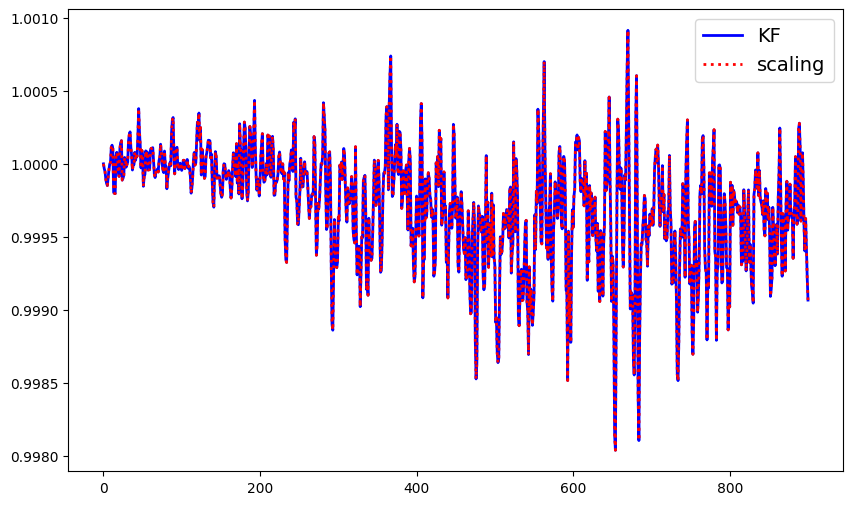

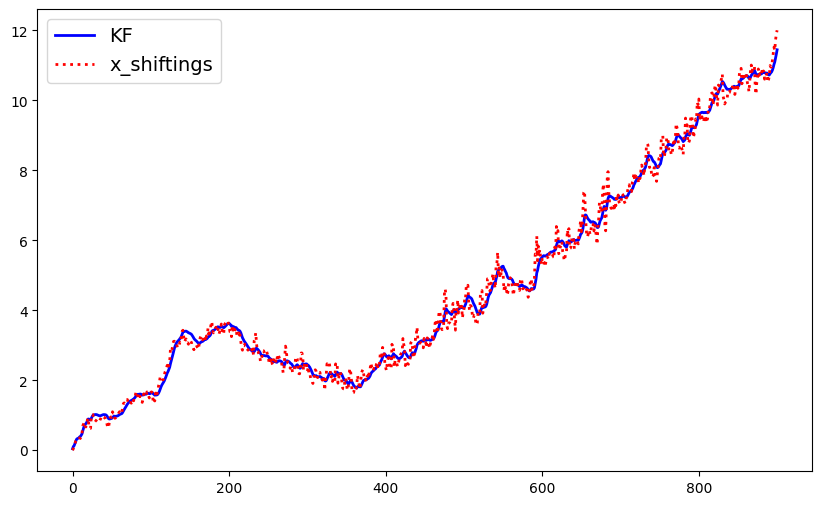

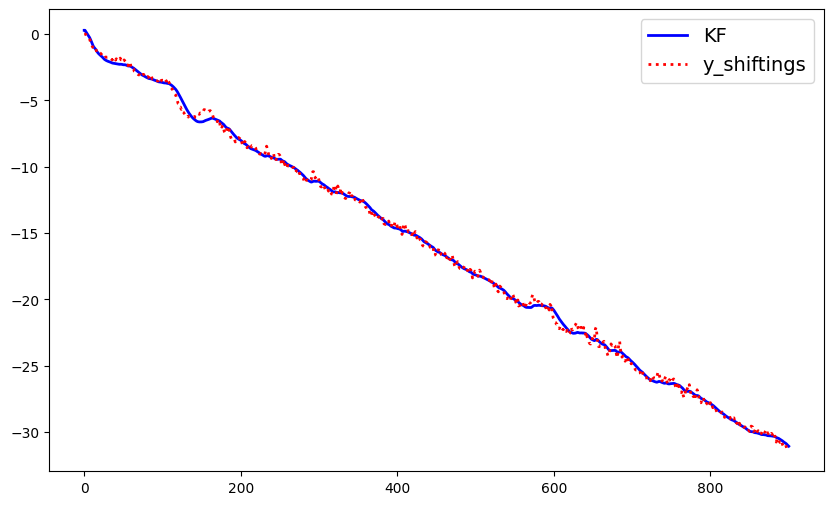

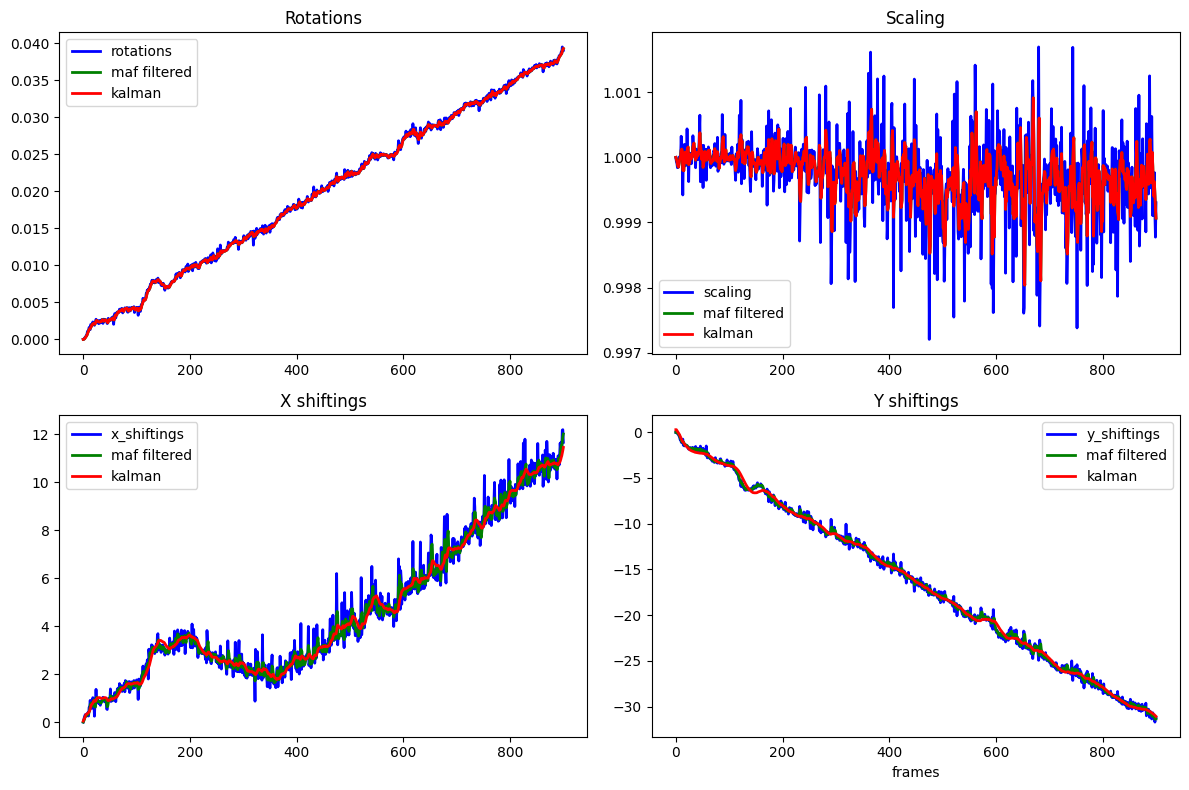

In [79]:
video_filtered_transformations = filter_affine_transformations(video_affine_transformations, with_interpolation=False, with_kalman=False)

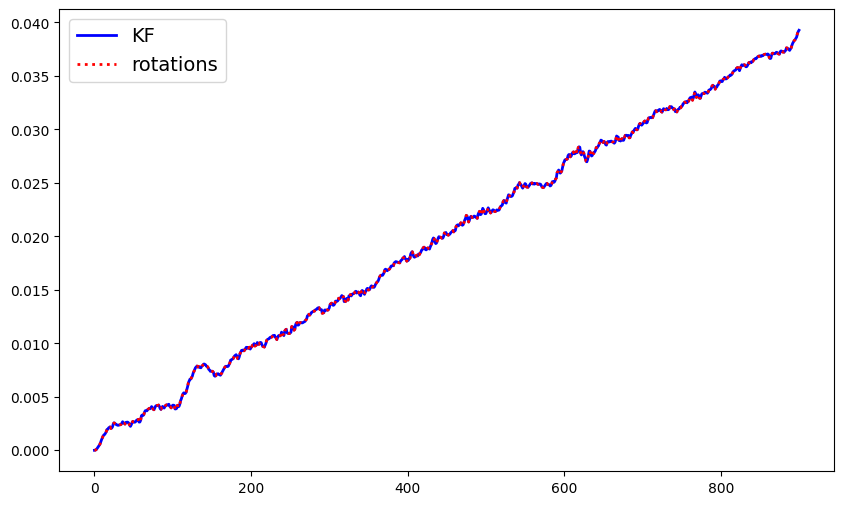

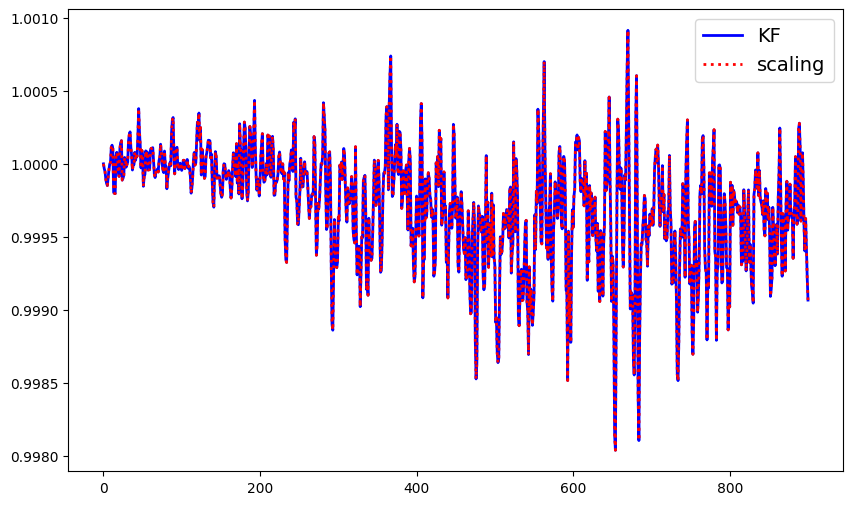

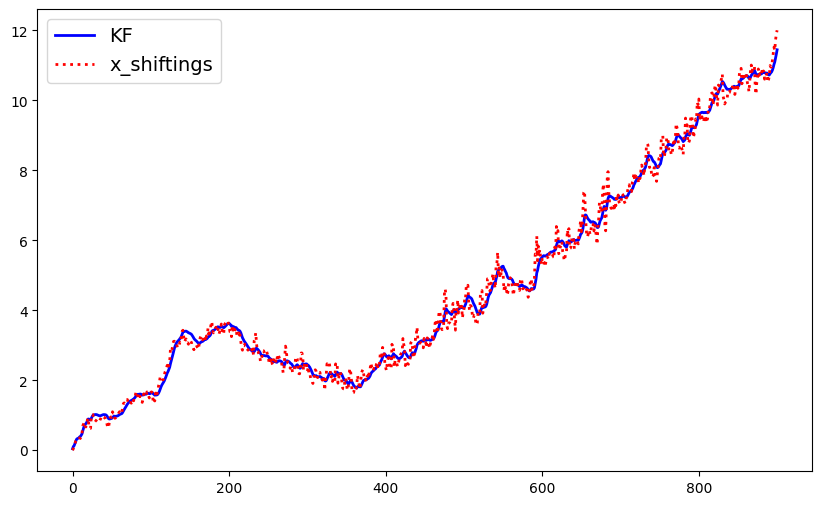

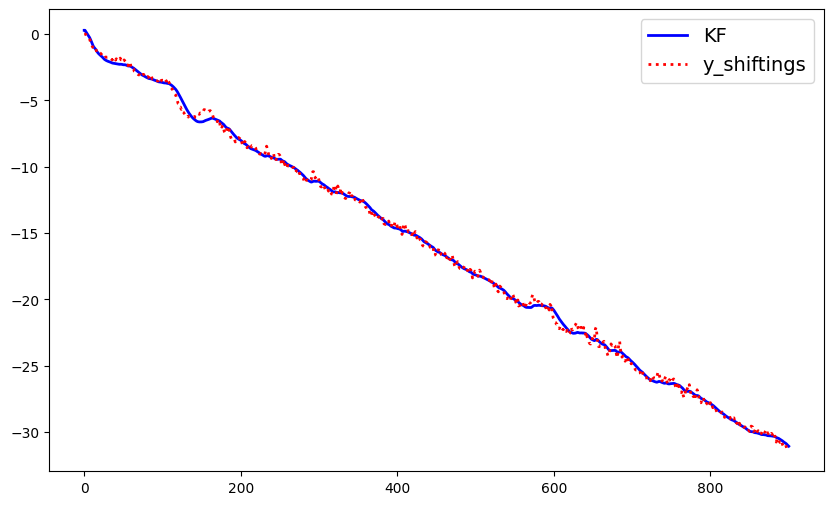

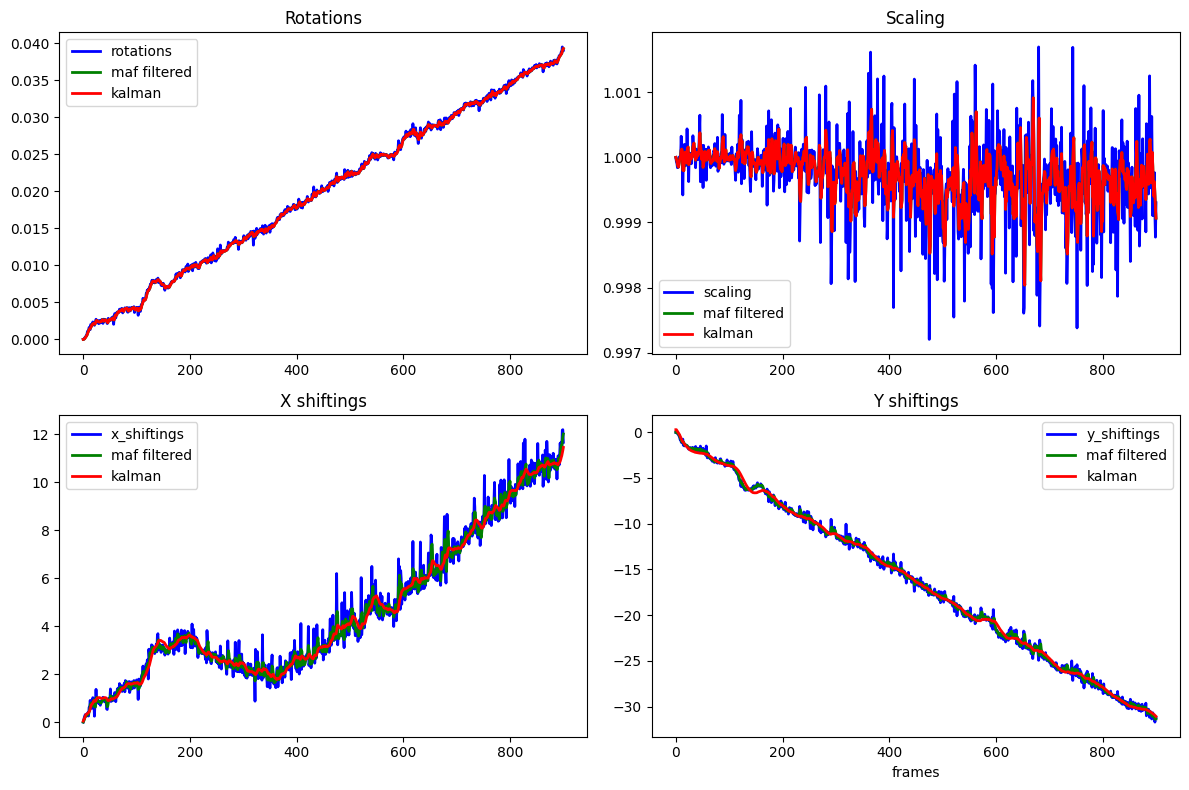

In [80]:
kalman_video_filtered_transformations = filter_affine_transformations(video_affine_transformations, with_kalman=True)

In [81]:
# @title Paso 4: Procesar Video {form-width: "25%"}
def process_video(input_path, output_path, transformations):
  # Open the video file for reading
  video_capture = cv2.VideoCapture(input_path)

  # Get video properties
  fps = video_capture.get(cv2.CAP_PROP_FPS)
  width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
  
  # Create VideoWriter object to save the output video
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

  frame_count = 0
  while True:
    
    ret, frame = video_capture.read()
      
    if not ret:
      break

    frame_processed = cv2.warpAffine(frame, transformations[frame_count], (frame.shape[1], frame.shape[0]))
    
    # Write the processed frame to the output video file
    video_writer.write(frame_processed)

    frame_count += 1
    if (frame_count % 100 == 0):
      print(f"Processed frame {frame_count}/{total_frames}")

  # Release the video capture and writer objects
  video_capture.release()
  video_writer.release()

output_video_path1 = VIDEO_PATH.replace(".mp4", f"_{METHOD}_estabilizado.mp4")
output_video_path2 = VIDEO_PATH.replace(".mp4", f"_{METHOD}_estabilizado_filtrado.mp4")
output_video_path3 = VIDEO_PATH.replace(".mp4", f"_{METHOD}_estabilizado_filtrado_kalman.mp4")

process_video(VIDEO_PATH, output_video_path1, video_affine_transformations)
process_video(VIDEO_PATH, output_video_path2, video_filtered_transformations)
process_video(VIDEO_PATH, output_video_path3, kalman_video_filtered_transformations)

Processed frame 100/901
Processed frame 200/901
Processed frame 300/901
Processed frame 400/901
Processed frame 500/901
Processed frame 600/901
Processed frame 700/901
Processed frame 800/901
Processed frame 900/901
Processed frame 100/901
Processed frame 200/901
Processed frame 300/901
Processed frame 400/901
Processed frame 500/901
Processed frame 600/901
Processed frame 700/901
Processed frame 800/901
Processed frame 900/901
Processed frame 100/901
Processed frame 200/901
Processed frame 300/901
Processed frame 400/901
Processed frame 500/901
Processed frame 600/901
Processed frame 700/901
Processed frame 800/901
Processed frame 900/901
